### Project Members: Naman Jain(nj2387), Syed Sarfaraz Akhtar(ssa2184), Varun Chanddra(vc2491)
Model Folder: [Drive](https://drive.google.com/open?id=1U-u1qTOBkcQiEX49JLFBww-AN3yT4sk3)

GitHub Link: [GitHub](https://github.com/toshi1801/applied_dl_project)

Demo: [YouTube](https://youtu.be/YUwZXfL4RXQ)

This file is specifically for testing the models trained in another [notebook](https://github.com/toshi1801/applied_dl_project/blob/master/adl_project_main.ipynb).

This file can be run without any restrictions. 

We load 2 best models here and then average their output to generate the mask.
Three images are tested here.


In [0]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import copy
import math
import os
import subprocess

import numpy as np
import tensorflow as tf

from openslide import open_slide, __library_version__ as openslide_version
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.metrics import mean_iou

In [0]:
# Download test data and Model

def download_data(slide_path, tumor_mask_path):

    slide_url = 'https://storage.googleapis.com/applied_dl/data/{}'.format(slide_path)
    mask_url = 'https://storage.googleapis.com/applied_dl/data/{}'.format(tumor_mask_path) 

    # Download the whole slide image
    if not os.path.exists(slide_path):
      !curl -O $slide_url

    # Download the tumor mask
    if not os.path.exists(tumor_mask_path):
      !curl -O $mask_url
    

def download_model(model):
    model_url = 'https://storage.googleapis.com/applied_dl/model/{}'.format(model)
    if not os.path.exists(model):
        !curl -O $model_url
        !unzip $model
        !rm $model

In [0]:
test_list = [['tumor_075.tif', 'tumor_075_mask.tif'], ['tumor_081.tif', 'tumor_081_mask.tif'], ['tumor_084.tif', 'tumor_084_mask.tif']]
models = ['model2_a.zip', 'model2_b.zip']

In [0]:
for image in test_list:
    slide = image[0]
    mask = image[1]
    download_data(slide, mask)

for model in models:
    !rm -rf $model
    download_model(model)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1118M  100 1118M    0     0  76.2M      0  0:00:14  0:00:14 --:--:-- 82.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39.1M  100 39.1M    0     0  39.1M      0  0:00:01  0:00:01 --:--:-- 39.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  799M  100  799M    0     0  78.8M      0  0:00:10  0:00:10 --:--:-- 86.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.7M  100 24.7M    0     0  40.0M      0 --:--:-- --:--:-- --:--:-- 39.9M
  % Total    % Received % Xferd  Average Speed   Tim

In [0]:
def load_slides(slide_path, tumor_mask_path):
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                            slide.level_dimensions[0][0], 
                                                            slide.level_dimensions[0][1]))

    tumor_mask = open_slide(tumor_mask_path)
    print ("Read tumor mask from %s" % (tumor_mask_path))

    print("Slide includes %d levels" % len(slide.level_dimensions))
    for i in range(8): # We are only concerned with first 8 levels.
        print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                                 slide.level_dimensions[i], 
                                                                 slide.level_downsamples[i]))
        assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
        assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

    # Verify downsampling works as expected
    width, height = slide.level_dimensions[7]
    assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
    assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
    return slide, tumor_mask

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
def plot_tumor_slide(slide, level, plot_image=False):
    slide_image = read_slide(slide, 
                             x=0, 
                             y=0, 
                             level=level, 
                             width=slide.level_dimensions[level][0], 
                             height=slide.level_dimensions[level][1])

    if plot_image:
        plt.figure(figsize=(5,5), dpi=100)
        plt.imshow(slide_image)
    return slide_image

In [0]:
def plot_tumor_mask(slide, mask, level, plot_image=False):
    mask_image = read_slide(mask, 
                            x=0, 
                            y=0, 
                            level=level, 
                            width=slide.level_dimensions[level][0], 
                            height=slide.level_dimensions[level][1])

    mask_image = mask_image[:,:,0]
    
    if plot_image:
        plt.figure(figsize=(5,5), dpi=100)
        plt.imshow(mask_image)
    return mask_image

In [0]:
def get_slide_and_mask_for_level(slide_list, level, overlay=False):
    slide_image_list = []
    mask_image_list = []
    for i in range(len(slide_list)):
        slide_image = plot_tumor_slide(slide_list[i][0], level)
        mask_image = plot_tumor_mask(slide_list[i][0], slide_list[i][1], level)
        slide_image_list.append(slide_image)
        mask_image_list.append(mask_image)
        if overlay:
            overlay_slide_and_mask(slide_image, mask_image)
    return slide_image_list, mask_image_list

In [0]:
def overlay_slide_and_mask(slide_image, mask_image):
    plt.figure(figsize=(5,5), dpi=100)
    plt.imshow(slide_image)
    plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
frame_size = 100
frame_width , frame_height = frame_size, frame_size

center = 60
lower = int(math.floor(frame_size - center) / 2)
upper = int(math.ceil(frame_size - center) / 2)

In [0]:
def get_label(mask_image, x, y):
    if mask_image[x + lower : x + frame_width - upper, y + lower: y + frame_height - upper].sum() > 0:
        return 1
    return 0

In [0]:
def extract_slide_frames(slide_image, mask_image):
    images = []
    labels = []
    width, height = slide_image.shape[0], slide_image.shape[1]
    for i in range(0, width - frame_width + 1, frame_size):
        for j in range(0, height - frame_height + 1, frame_size):
            image = slide_image[i : i + frame_width, j : j +  frame_height, :]
            images.append(image)
            label = get_label(mask_image, i, j)
            labels.append(label)
    images = np.asarray(images)
    labels = np.asarray(labels)
    return images, labels

In [0]:
def generate_test_dataset(test_slide_image_list, test_mask_image_list):
    test_array = []
    for i in range(len(test_slide_image_list)):
        x_test, y_test = extract_slide_frames(test_slide_image_list[i], test_mask_image_list[i])
        test_array.append([x_test, y_test])

    for test in test_array:
        print(test[0].shape, test[1].shape)
    return test_array

In [0]:
def evaluate_model(model, x_test, y_test):
        
    scores = model.evaluate(x_test, y_test)
    y_predict = model.predict(x_test)
    y_predict_prob = model.predict_proba(x_test)
    y_predict_label = model.predict_classes(x_test)
    print(y_predict_label.shape)
    
    print('Loss: ', scores[0])
    print('Acc: ', scores[1])
    print('Precision: ', precision_score(y_test, y_predict_label))
    print('Recall: ', recall_score(y_test, y_predict_label))
    print('F1: ', f1_score(y_test, y_predict_label))
    print('AUCROC: ', roc_auc_score(y_test, y_predict_label))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_predict_label))
    
    return y_predict_label, y_predict_prob

In [0]:
test_slide_list = []
for i in range(len(test_list)):
    test_slide, test_mask = load_slides(test_list[i][0],test_list[i][1])
    test_slide_list.append([test_slide, test_mask])

Read WSI from tumor_075.tif with width: 90112, height: 78848
Read tumor mask from tumor_075_mask.tif
Slide includes 9 levels
Level 0, dimensions: (90112, 78848) downsample factor 1
Level 1, dimensions: (45056, 39424) downsample factor 2
Level 2, dimensions: (22528, 19712) downsample factor 4
Level 3, dimensions: (11264, 9856) downsample factor 8
Level 4, dimensions: (5632, 4928) downsample factor 16
Level 5, dimensions: (2816, 2464) downsample factor 32
Level 6, dimensions: (1408, 1232) downsample factor 64
Level 7, dimensions: (704, 616) downsample factor 128
Read WSI from tumor_081.tif with width: 90112, height: 100352
Read tumor mask from tumor_081_mask.tif
Slide includes 9 levels
Level 0, dimensions: (90112, 100352) downsample factor 1
Level 1, dimensions: (45056, 50176) downsample factor 2
Level 2, dimensions: (22528, 25088) downsample factor 4
Level 3, dimensions: (11264, 12544) downsample factor 8
Level 4, dimensions: (5632, 6272) downsample factor 16
Level 5, dimensions: (2816,

In [0]:
test_slide_image_list, test_mask_image_list = get_slide_and_mask_for_level(test_slide_list, 3)

In [0]:
test_sample = generate_test_dataset(test_slide_image_list, test_mask_image_list)

(10976, 100, 100, 3) (10976,)
(14000, 100, 100, 3) (14000,)
(8667, 100, 100, 3) (8667,)


In [0]:
test_image_1 = test_sample[0]
test_slide_image_1 = test_slide_image_list[0]

test_image_2 = test_sample[1]
test_slide_image_2 = test_slide_image_list[1]

test_image_3 = test_sample[2]
test_slide_image_3 = test_slide_image_list[2]

In [0]:
test_slide_image_1.shape

(9856, 11264, 3)

In [0]:
model1 = tf.contrib.saved_model.load_keras_model('model2_a/1558050741')
model1.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-4), loss='binary_crossentropy', metrics = ['acc'])


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model2 = tf.contrib.saved_model.load_keras_model('model2_b/1558050788')
model2.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-4), loss='binary_crossentropy', metrics = ['acc'])

In [0]:
def evaluate_image(model, test_image, test_slide_image, reshape_size, plot=True):
    
    incep_predict_label, incep_predict_prob = evaluate_model(model, test_image[0], test_image[1])

    with tf.Session() as session:
        iou, conf_mat = tf.metrics.mean_iou(tf.convert_to_tensor(test_image[1].reshape((test_image[1].shape[0], 1))), 
                                            tf.convert_to_tensor(incep_predict_label), num_classes=2)
        session.run(tf.local_variables_initializer())
        session.run([conf_mat])
        miou = session.run([iou])
        print(miou)
    
    if plot:
        incep_prob_image = np.reshape(incep_predict_prob, (-1, reshape_size))
        overlay_slide_and_mask(test_slide_image, incep_prob_image)
        
    return incep_predict_label, incep_predict_prob

In [0]:
def apply_threshold(prob_image, threshold):
    prob_image_threshold = copy.deepcopy(prob_image)
    super_threshold_indices = prob_image_threshold < threshold
    prob_image_threshold[super_threshold_indices] = 0
    return prob_image_threshold

Image 1

In [0]:
incep_predict_label_m1_image_1, incep_predict_prob_m1_image_1 = evaluate_image(model1, test_image_1, test_slide_image_1, 122, plot=False)
incep_predict_label_m2_image_1, incep_predict_prob_m2_image_1 = evaluate_image(model2, test_image_1, test_slide_image_1, 122, plot=False)

incep_predict_prob_avg_image_1 = (np.array(incep_predict_prob_m1_image_1) + np.array(incep_predict_prob_m2_image_1)) / 2

10976/10976 [==============================] - 16s 1ms/sample - loss: 0.1274 - acc: 0.9858
(10976, 1)
Loss:  0.12735803827892447
Acc:  0.98578715
Precision:  0.5185185185185185
Recall:  0.35
F1:  0.417910447761194
AUCROC:  0.6725961538461539
Confusion Matrix: 
 [[10764    52]
 [  104    56]]
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
[0.6249326]
10976/10976 [==============================] - 12s 1ms/sample - loss: 0.1094 - acc: 0.9862
(10976, 1)
Loss:  0.1093701447908605
Acc:  0.9861516
Precision:  0.5408163265306123
Recall:  0.33125
F1:  0.4108527131782946
AUCROC:  0.6635447485207101
Confusion Matrix: 
 [[10771    45]
 [  107    53]]
[0.6223105]


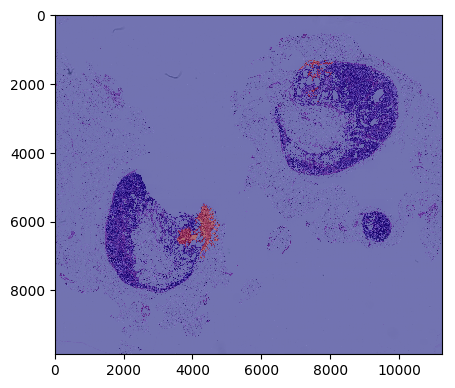

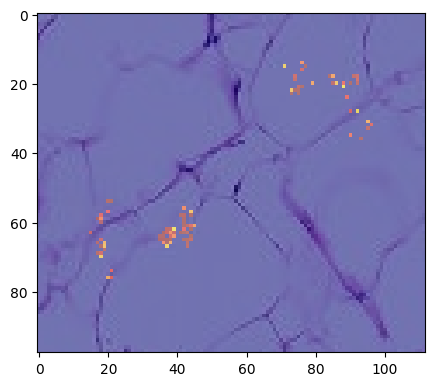

In [0]:
incep_prob_image_avg_image_1 = np.reshape(incep_predict_prob_avg_image_1, (-1, 112))
incep_prob_image_avg_image_1_threshold = apply_threshold(incep_prob_image_avg_image_1, 0.65)
overlay_slide_and_mask(test_slide_image_1, test_mask_image_list[0])
overlay_slide_and_mask(test_slide_image_1, incep_prob_image_avg_image_1_threshold)

Image 2

In [0]:
incep_predict_label_m1_image_2, incep_predict_prob_m1_image_2 = evaluate_image(model1, test_image_2, test_slide_image_2, 112, plot=False)
incep_predict_label_m2_image_2, incep_predict_prob_m2_image_2 = evaluate_image(model2, test_image_2, test_slide_image_2, 112, plot=False)
incep_predict_prob_avg_image_2 = (np.array(incep_predict_prob_m1_image_2) + np.array(incep_predict_prob_m2_image_2)) / 2

14000/14000 [==============================] - 16s 1ms/sample - loss: 0.0086 - acc: 0.9967
(14000, 1)
Loss:  0.0085657637290979
Acc:  0.9967143
Precision:  0.0425531914893617
Recall:  0.6666666666666666
F1:  0.08
AUCROC:  0.8317258460146222
Confusion Matrix: 
 [[13952    45]
 [    1     2]]
[0.51919025]
14000/14000 [==============================] - 15s 1ms/sample - loss: 0.0078 - acc: 0.9972
(14000, 1)
Loss:  0.00784449018647438
Acc:  0.99721426
Precision:  0.05
Recall:  0.6666666666666666
F1:  0.09302325581395349
AUCROC:  0.8319758995975327
Confusion Matrix: 
 [[13959    38]
 [    1     2]]
[0.5229972]


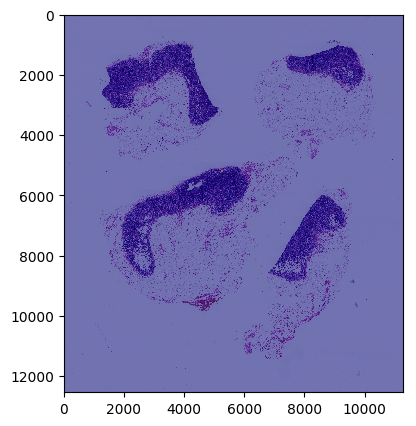

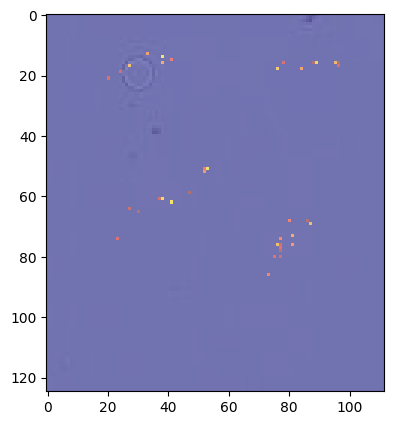

In [0]:
incep_prob_image_avg_image_2 = np.reshape(incep_predict_prob_avg_image_2, (-1, 112))
incep_prob_image_avg_image_2_threshold = apply_threshold(incep_prob_image_avg_image_2, 0.65)
overlay_slide_and_mask(test_slide_image_2, test_mask_image_list[1])
overlay_slide_and_mask(test_slide_image_2, incep_prob_image_avg_image_2_threshold)

Image 3

In [0]:
incep_predict_label_m1_image_3, incep_predict_prob_m1_image_3 = evaluate_image(model1, test_image_3, test_slide_image_3, 112, plot=False)
incep_predict_label_m2_image_3, incep_predict_prob_m2_image_3 = evaluate_image(model2, test_image_3, test_slide_image_3, 112, plot=False)
incep_predict_prob_avg_image_3 = (np.array(incep_predict_prob_m1_image_3) + np.array(incep_predict_prob_m2_image_3)) / 2

8667/8667 [==============================] - 10s 1ms/sample - loss: 0.1042 - acc: 0.9868
(8667, 1)
Loss:  0.10424107150663231
Acc:  0.9868467
Precision:  0.2222222222222222
Recall:  0.038461538461538464
F1:  0.0655737704918033
AUCROC:  0.5184132987180985
Confusion Matrix: 
 [[8549   14]
 [ 100    4]]
[0.5103695]
8667/8667 [==============================] - 9s 1ms/sample - loss: 0.0759 - acc: 0.9871
(8667, 1)
Loss:  0.07588231069641077
Acc:  0.9870774
Precision:  0.16666666666666666
Recall:  0.019230769230769232
F1:  0.034482758620689655
AUCROC:  0.509031477106334
Confusion Matrix: 
 [[8553   10]
 [ 102    2]]
[0.50230914]


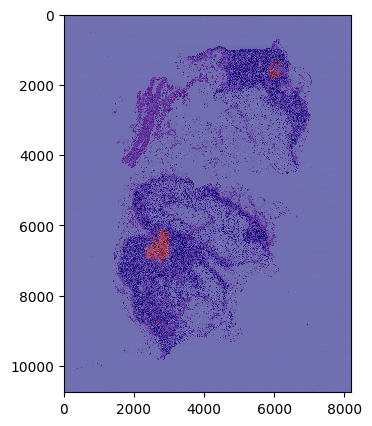

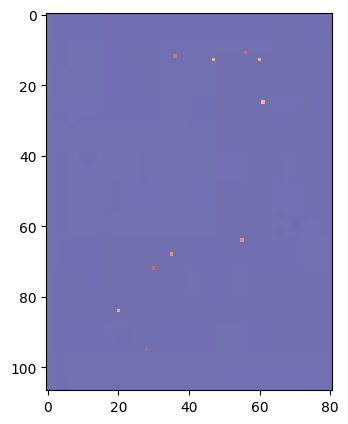

In [0]:
incep_prob_image_avg_image_3 = np.reshape(incep_predict_prob_avg_image_3, (-1, 81))
incep_prob_image_avg_image_3_threshold = apply_threshold(incep_prob_image_avg_image_3, 0.65)
overlay_slide_and_mask(test_slide_image_3, test_mask_image_list[2])
overlay_slide_and_mask(test_slide_image_3, incep_prob_image_avg_image_3_threshold)